In [1]:
import dill
import itertools
import numpy as np
import multiprocessing
from pauli_channel_approximation import compute_dpn_and_fid
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

In [2]:
%%bash 
ls

diamond.py
Example data unpacking.ipynb
GRAPE.py
notebooks
pauli_channel_approximation.py
pickled_controls228.pkl
pickled_controls245.pkl
pickled_controls261.pkl
__pycache__
Quadratic Programs.ipynb
README.md


In [57]:
"""
These pkl files contain PCA objects that define the Hamiltonian, 
the controls that were generated, the standard deviation of the controls
used in the robust optimization, etc
"""

pca228 = dill.load(open("pickled_controls228.pkl", 'rb')) # SQRTY 
pca245 = dill.load(open("pickled_controls245.pkl", 'rb')) # SQRTX
pca261 = dill.load(open("pickled_controls261.pkl", 'rb')) # SQRT(ZZ)
pca = pca245
pca263 = dill.load(open("../../../randomized_controls/pickled_controls263.pkl", 'rb'))
pca = pca261


In [58]:
from functools import reduce
import scipy
from copy import deepcopy
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
from GRAPE import control_unitaries
controlset, ambient_hamiltonian0, dt, control_hamiltonians, target_operator = pca.controlset, pca.ambient_hamiltonian, pca.dt, pca.control_hamiltonians, pca.target_operator
combo = (0, 0, 0)
# error_generators = []
us = []
# Compute the adjoint once
# adjoint_target = np.conj(target_operator.T)
for controls in controlset:
    newcontrols = deepcopy(controls)
    ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
    for cnum, value in enumerate(combo):
        cnum -= len(ambient_hamiltonian0)
        if cnum >= 0:
            newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
        if cnum < 0:
            ambient_hamiltonian[cnum] *= float(value)
    controls = newcontrols
    #print(newcontrols)
    step_unitaries = control_unitaries(ambient_hamiltonian,
                                       control_hamiltonians, newcontrols,
                                       dt)
    unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
    us.append(unitary)
    
#     error_u = np.dot(adjoint_target, unitary)
#     error_ham = scipy.linalg.logm(error_u)
#     error_generators.append(-1.j * error_ham)
    
# But this is only right if the generator is time independent. For shame!

In [59]:
# We have two controls, X and Y, and one control knob -
# the amplitude at each time step, but we will assume this is quasi-static. So we vec it.

In [10]:
import operator as op
from functools import reduce
from math import factorial
from itertools import permutations

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer//denom


def build_control_derivatives(a, ham):
    """Build the ath order derivatives of the given Hamiltonian, assumed to be piecewise constant (i.e. GRAPE)
    ham should be a matrix whose columns are the "terms in the hamiltonian corresponding to a unique knob"."""
    if a == 0:
        return ham
    indices = list(product(*[list(range(ham.shape[1])) for _ in range(a)]))
    top_dim = ncr(ham.shape[1], a)
    res = np.zeros((ham.shape[0], len(indices)))
    for i, index in enumerate(indices):
        if any(np.unique(index, return_counts=True)[1] > 1):
            res[:, i] = 0
        else:
            res[:, i] = np.prod([ham[:, ind] for ind in index], axis=0)
    return res

In [7]:
def stack_1q_control(control):
    for i in range(control.shape[1]):
        control[:, i] -= np.mean(control[:, i])
    control = control.T.reshape(control.size, -1)
    control = np.hstack([control, np.ones(control.shape)])
    return control

In [45]:
def stack_2q_control(control):
    for i in range(control.shape[1]):
        control[:, i] -= np.mean(control[:, i])
    zeros = np.zeros(control[:, 0:1].shape)
    vecs = [np.vstack([control[:, 0:1], zeros]),
            np.vstack([control[:, 1:2], zeros]),
            np.vstack([control[:, 2:3], control[:, 3:4]]),
            np.vstack([control[:, 4:5], zeros]),
            np.ones((control[:,0:1].shape[0]*2, 1)),
            np.ones((control[:,0:1].shape[0]*2, 1))]
    control = np.hstack(vecs)
    return control

In [56]:
stack_2q_control(pca.controlset[0]).shape

(800, 1)
(800, 1)
(800, 1)
(800, 1)
(800, 1)
(800, 1)


(800, 6)

In [35]:
build_control_derivatives(1, stack_1q_control(pca.controlset[0])).shape

(20, 2)

In [36]:
# So we need to make 2RBCs?

In [3]:
import cvxpy as cp
import numpy as np
def optimal_weights_1q(controlset, i):
    controls = [stack_1q_control(control) for control in controlset]
    omega = cp.Variable(len(controls))
    
    all_derivs = [build_control_derivatives(i, control).flatten() for control in controls]
    objective = cp.Minimize(cp.norm(np.matrix(all_derivs).T*omega))
    constraints = [0 <= omega, omega <= 1, sum(omega)==1]
    for j in range(i):
        if j == 1:
            # These are the same as 0...
            continue 
        all_derivs = []
        for control in controls:
            derivs = build_control_derivatives(j, control).T.flatten()
            assert len(derivs) % 2 == 0
            derivs = derivs[:int(len(derivs)/2)]
            all_derivs.append(derivs)
        constraints += [(np.matrix(all_derivs).T)*omega == 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return omega.value

In [41]:
import cvxpy as cp
import numpy as np
def optimal_weights_2q(controlset, i):
    controls = [stack_2q_control(control) for control in controlset]
    omega = cp.Variable(len(controls))
    
    all_derivs = [build_control_derivatives(i, control).flatten() for control in controls]
    objective = cp.Minimize(cp.norm(np.matrix(all_derivs).T*omega))
    constraints = [0 <= omega, omega <= 1, sum(omega)==1]
    for j in range(i):
        if j == 1:
            # These are the same as 0...
            continue 
        all_derivs = []
        for control in controls:
            derivs = build_control_derivatives(j, control).T.flatten()
            assert len(derivs) % 2 == 0
            derivs = derivs[:int(len(derivs)/2)]
            all_derivs.append(derivs)
        constraints += [(np.matrix(all_derivs).T)*omega == 0]
    print(len(constraints))
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return omega.value

In [70]:
weights = optimal_weights_2q(pca.controlset, 0)

3


In [71]:
print(weights)

[[0.04895847]
 [0.05378717]
 [0.04365426]
 [0.05142995]
 [0.0573495 ]
 [0.05053136]
 [0.05511908]
 [0.04179991]
 [0.0493987 ]
 [0.03944658]
 [0.06231261]
 [0.0490475 ]
 [0.04980955]
 [0.04824159]
 [0.04892015]
 [0.03904955]
 [0.04445302]
 [0.06022598]
 [0.05279895]
 [0.05366612]]


In [51]:
pca.probs = list(np.array(weights).flatten())

In [72]:
"""
These pkl files contain PCA objects that define the Hamiltonian, 
the controls that were generated, the standard deviation of the controls
used in the robust optimization, etc
"""

pca228 = dill.load(open("pickled_controls228.pkl", 'rb')) # SQRTY 
pca245 = dill.load(open("pickled_controls245.pkl", 'rb')) # SQRTX
pca261 = dill.load(open("pickled_controls261.pkl", 'rb')) # SQRT(ZZ)
pca = pca245
#pca.probs = list(np.array(weights).flatten())
pca263 = dill.load(open("../../../randomized_controls/pickled_controls263.pkl", 'rb'))
pca = pca261
pca.probs = list(np.array(weights).flatten())

# First test with sum of squares

DOING COMBO [-0.001, -0.001, -0.001, -0.001, -0.001]
DOING COMBO [-0.001, 0.0, -0.001, 0.0, 0.0]
DOING COMBO [-0.001, 0.0, -0.001, 0.0, 0.001]
DOING COMBO [-0.001, -0.001, -0.001, -0.001, 0.0]
DOING COMBO [-0.001, -0.001, -0.001, -0.001, 0.001]
DOING COMBO [-0.001, 0.0, -0.001, 0.001, -0.001]
DOING COMBO [-0.001, 0.0, -0.001, 0.001, 0.0]
DOING COMBO [-0.001, -0.001, -0.001, 0.0, -0.001]
DOING COMBO [-0.001, 0.0, -0.001, 0.001, 0.001]
DOING COMBO [-0.001, -0.001, -0.001, 0.0, 0.0]
DOING COMBO [-0.001, 0.0, 0.0, -0.001, -0.001]
DOING COMBO [-0.001, -0.001, -0.001, 0.0, 0.001]
DOING COMBO [-0.001, 0.0, 0.0, -0.001, 0.0]
DOING COMBO [-0.001, -0.001, -0.001, 0.001, -0.001]
DOING COMBO [-0.001, 0.0, 0.0, -0.001, 0.001]
DOING COMBO [-0.001, -0.001, -0.001, 0.001, 0.0]
DOING COMBO [-0.001, 0.0, 0.0, 0.0, -0.001]
DOING COMBO [-0.001, -0.001, -0.001, 0.001, 0.001]
DOING COMBO [-0.001, 0.0, 0.0, 0.0, 0.0]
DOING COMBO [-0.001, -0.001, 0.0, -0.001, -0.001]
DOING COMBO [-0.001, 0.0, 0.0, 0.0, 0.001]

DOING COMBO [0.0, 0.001, 0.0, 0.001, -0.001]
DOING COMBO [0.001, -0.001, 0.001, -0.001, 0.001]
DOING COMBO [0.0, 0.001, 0.0, 0.001, 0.0]
DOING COMBO [0.001, -0.001, 0.001, 0.0, -0.001]
DOING COMBO [0.0, 0.001, 0.0, 0.001, 0.001]
DOING COMBO [0.001, -0.001, 0.001, 0.0, 0.0]
DOING COMBO [0.0, 0.001, 0.001, -0.001, -0.001]
DOING COMBO [0.001, -0.001, 0.001, 0.0, 0.001]
DOING COMBO [0.0, 0.001, 0.001, -0.001, 0.0]
DOING COMBO [0.001, -0.001, 0.001, 0.001, -0.001]
DOING COMBO [0.001, 0.001, -0.001, -0.001, 0.0]
DOING COMBO [0.001, 0.001, -0.001, -0.001, 0.001]
DOING COMBO [0.001, -0.001, 0.001, 0.001, 0.0]
DOING COMBO [0.001, -0.001, 0.001, 0.001, 0.001]
DOING COMBO [0.001, 0.001, -0.001, 0.0, -0.001]
DOING COMBO [0.001, 0.0, -0.001, -0.001, -0.001]
DOING COMBO [0.001, 0.001, -0.001, 0.0, 0.0]
DOING COMBO [0.001, 0.0, -0.001, -0.001, 0.0]
DOING COMBO [0.001, 0.001, -0.001, 0.0, 0.001]
DOING COMBO [0.001, 0.0, -0.001, -0.001, 0.001]
DOING COMBO [0.001, 0.001, -0.001, 0.001, -0.001]
DOING COM

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


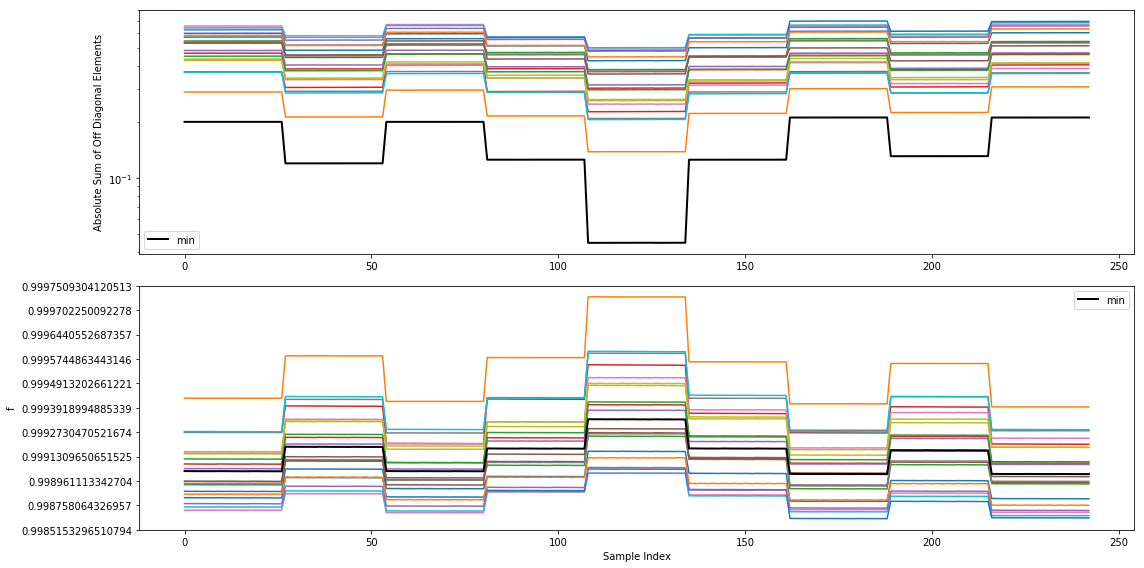

In [75]:
num_points = 3
num_processors = 2
def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
    return indices

values_to_plot = []
corr = []
for i, detuning in enumerate(pca.detunings):
    # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
    values = np.linspace(-detuning[0], detuning[0], num_points)
    values_to_plot.append(values)
    corr.append(i)
# This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
combinations = itertools.product(*values_to_plot)
new_combinations = []
for combo in combinations:
    new_combo = []
    for index in corr:
        new_combo.append(combo[index])
    new_combinations.append(new_combo)
combinations = new_combinations

tuple_length = len(combinations[0])
standard_ordering = list(range(tuple_length))
ordering = standard_ordering
indices = generate_indices(len(values), ordering)

# Multiprocessing for faster evaluation.
pool = multiprocessing.Pool(num_processors)
lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
        pca.control_hamiltonians, pca.target_operator, pca.probs)
       for combo in combinations]
projs_fidelities = pool.map(compute_dpn_and_fid, lst)
pool.close()

# Compute the off diagonals and fidelities.
projs = [pf[0] for pf in projs_fidelities]
fidelities = [pf[1] for pf in projs_fidelities]
projs = np.vstack(projs).T
fidelities = np.vstack(fidelities).T
plt.figure(figsize=(16, 8))  # the first figure
plt.subplot(211)  # the first subplot in the first figure

for i, row in enumerate(projs[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Absolute Sum of Off Diagonal Elements")
plt.semilogy()
plt.subplot(212)  # the second subplot in the first figure
for i, row in enumerate(fidelities[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), -np.log(1 - reordered_row))
plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("f")
samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
labels = -(np.exp(-samples) - 1)
plt.xlabel("Sample Index")
plt.tight_layout()
plt.yticks(samples, labels)
plt.tight_layout()
plt.show()


In [140]:
%%bash
ls 

diamond.py
Example data unpacking.ipynb
GRAPE.py
pauli_channel_approximation.py
pickled_controls228.pkl
pickled_controls245.pkl
pickled_controls261.pkl
__pycache__
Quadratic Programs.ipynb
README.md


In [13]:
pca263 = dill.load(open("../../../randomized_controls/pickled_controls263.pkl", 'rb'))
pca = pca263

In [14]:
weights = optimal_weights_1q(pca.controlset, 3)

5


In [30]:
pca263 = dill.load(open("../../../randomized_controls/pickled_controls263.pkl", 'rb'))
pca = pca263
pca.probs = list(np.array(weights).flatten())

[0.0065126657051058755,
 0.00632032485682026,
 0.01251817648494495,
 0.012369693499926082,
 0.016889472330628503,
 0.005782105676826597,
 0.045571680212959084,
 0.016476152600530123,
 0.011055023060781426,
 0.022262582319658115,
 0.013080512014704117,
 0.017128160724800817,
 0.016015302323751607,
 0.00976863214138078,
 0.009477050665161389,
 0.013488996665083674,
 0.010553962555981634,
 0.027343831579580407,
 0.015632867735193248,
 0.01897201081957994,
 0.00780547595509753,
 0.01298487680979653,
 0.007295890564118872,
 0.019312144036751105,
 0.01395449445104451,
 0.02119588811547297,
 0.0009726104949812753,
 0.0059733071589597704,
 0.017150890622337905,
 0.007766976642551487,
 0.008717680342169057,
 0.013192405943492351,
 0.019506564408992837,
 0.008682242734670722,
 0.004830843580762444,
 0.011993185073164249,
 0.03804003519829475,
 0.007399270487666958,
 0.024468271757440395,
 0.007815874701542831,
 0.008005252959913747,
 0.005962739919588774,
 0.0063414327472904215,
 0.0067466870655

DOING COMBO [-0.001, -0.001]
DOING COMBO [-0.001, 0.001]
DOING COMBO [-0.001, 0.0]
DOING COMBO [0.0, -0.001]
DOING COMBO [0.0, 0.0]
DOING COMBO [0.001, -0.001]
DOING COMBO [0.0, 0.001]
DOING COMBO [0.001, 0.0]
DOING COMBO [0.001, 0.001]


/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


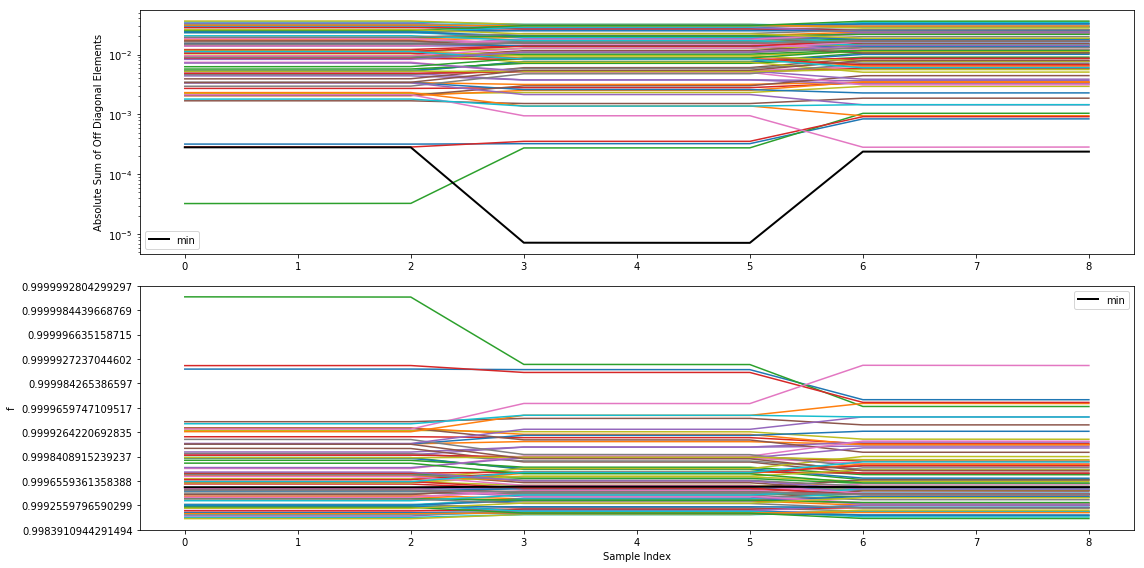

In [31]:
num_points = 3
num_processors = 2
def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
    return indices

values_to_plot = []
corr = []
for i, detuning in enumerate(pca.detunings):
    # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
    values = np.linspace(-detuning[0], detuning[0], num_points)
    values_to_plot.append(values)
    corr.append(i)
# This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
combinations = itertools.product(*values_to_plot)
new_combinations = []
for combo in combinations:
    new_combo = []
    for index in corr:
        new_combo.append(combo[index])
    new_combinations.append(new_combo)
combinations = new_combinations

tuple_length = len(combinations[0])
standard_ordering = list(range(tuple_length))
ordering = standard_ordering
indices = generate_indices(len(values), ordering)

# Multiprocessing for faster evaluation.
pool = multiprocessing.Pool(num_processors)
lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
        pca.control_hamiltonians, pca.target_operator, pca.probs)
       for combo in combinations]
projs_fidelities = pool.map(compute_dpn_and_fid, lst)
pool.close()

# Compute the off diagonals and fidelities.
projs = [pf[0] for pf in projs_fidelities]
fidelities = [pf[1] for pf in projs_fidelities]
projs = np.vstack(projs).T
fidelities = np.vstack(fidelities).T
plt.figure(figsize=(16, 8))  # the first figure
plt.subplot(211)  # the first subplot in the first figure

for i, row in enumerate(projs[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Absolute Sum of Off Diagonal Elements")
plt.semilogy()
plt.subplot(212)  # the second subplot in the first figure
for i, row in enumerate(fidelities[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), -np.log(1 - reordered_row))
plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("f")
samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
labels = -(np.exp(-samples) - 1)
plt.xlabel("Sample Index")
plt.tight_layout()
plt.yticks(samples, labels)
plt.tight_layout()
plt.show()


In [46]:
pca267 = dill.load(open("../../../randomized_controls/pickled_controls267.pkl", 'rb'))
pca = pca267
weights = optimal_weights_2q(pca.controlset, 1)

4


In [47]:
weights

In [38]:
len(pca267.controlset)

100

In [ ]:
pca267 = dill.load(open("../../../randomized_controls/pickled_controls267.pkl", 'rb'))
pca = pca267
pca.probs = list(np.array(weights).flatten())